In [2]:
using DrWatson
@quickactivate :SwARExperiments

In [3]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots
using Random
using Parameters
using LinearAlgebra
import ProgressMeter

In [4]:
using Plots
using PGFPlotsX
using LaTeXStrings
using ColorSchemes
pgfplotsx()
push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [25]:
using WAV
signal, fs = WAV.wavread("../data/btb.wav")

([-0.0019226660969878231; -0.005615405743583483; … ; -0.0067445905941953795; -0.0025940733054597613], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x49, 0x6e, 0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a])])

In [32]:
ds_signal = signal[1:10:end]

6336-element Vector{Float64}:
 -0.0019226660969878231
  0.0008545182653279214
  0.003021332438123722
  3.051850947599719e-5
 -0.021149327066866053
  0.011932737205114903
  0.004699850459303568
 -0.003021332438123722
 -0.008209479049043246
  0.014923551133762628
  ⋮
 -0.010376293221839045
 -0.005890072328867458
  0.007202368236335337
  0.017731254005554368
  0.0007629627368999298
  0.001892147587511826
 -0.0061037018951994385
 -0.004028443250831629
 -0.004058961760307627

In [33]:
fs

8000.0f0

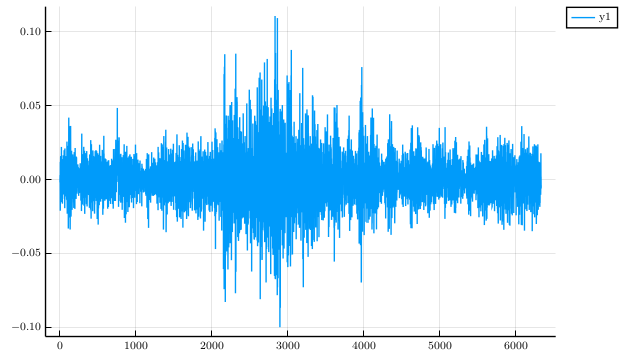

In [34]:
plot(ds_signal)

In [35]:
var(ds_signal[2000:4000])

0.0005755920568259142

In [36]:
var(ds_signal[1:2000])

0.00012076092747935885

## Switching AR

## Generate AR

In [64]:
seed = 2
n_samples = 5000
n_states = 2
ar_order = 2
l_slice = 100
n_buckets = div(n_samples, l_slice)

coefs_set = [generate_coefficients(seed*i,  ar_order) for i in 1:n_states]
prec_set  = sample(MersenneTwister(seed), [0.01, 0.1, 1.0, 10.0, 100.0], n_states, replace=false)
# prec_set  = sample(MersenneTwister(seed), [inv(0.00012076092747935885), inv(0.0005755920568259142)], n_states, replace=false)

gen_A, gen_states, observations = generateSwAR(seed, n_samples, l_slice, n_states, ones(n_states), coefs_set, prec_set)
inputs, outputs = observations[1], observations[2];

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

(GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

In [65]:
# ARorder = 2
# n_samples = length(ds_signal)-1
# inputs = ds_signal[1:n_samples+1]
# outputs = circshift(ds_signal, -1)

# inputs = inputs[1:end-1]
# outputs = outputs[2:end-1]

# inputs = [inputs[i+ARorder-1:-1:i] for i in 1:length(inputs)-ARorder]
# outputs = outputs[1:size(inputs, 1)];

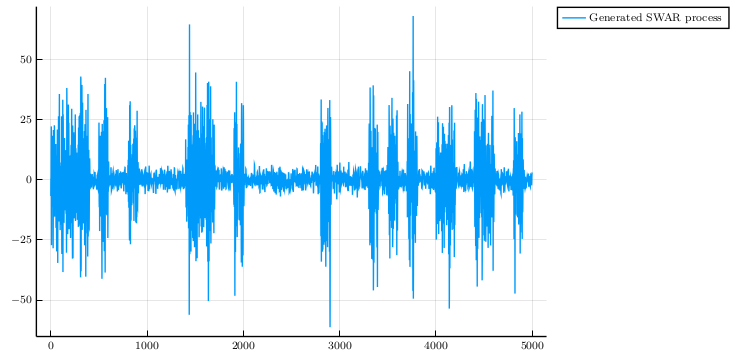

In [66]:
plot(outputs, label="Generated SWAR process")

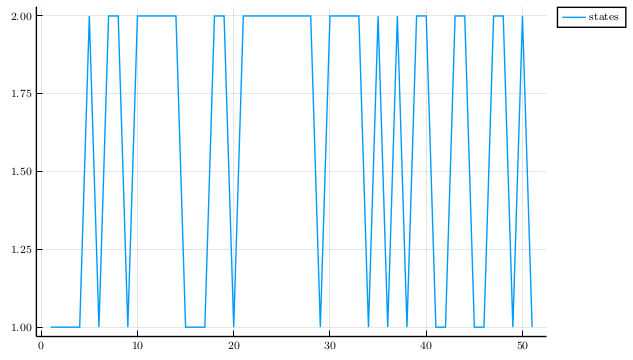

In [67]:
real_states = last.(findmax.(gen_states))
plot(real_states, label="states")

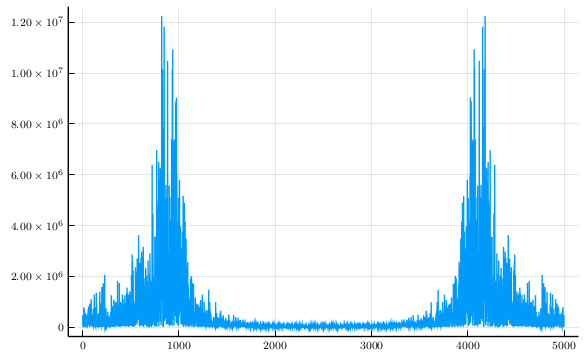

In [68]:
using FFTW
plot(abs.(fft(outputs)).^2, label=false)

In [69]:
# csep = 1000.0

priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A = generate_priors(coefs_set, prec_set)

parameters = SwARParameters(n_states, priors_as, priors_bs, priors_ms, priors_ws, prior_s, prior_A)


SwARParameters(2, GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=0.1, b=10.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], GammaShapeRate{Float64}[GammaShapeRate{Float64}(a=1000.0, b=1000.0), GammaShapeRate{Float64}(a=1000.0, b=1000.0)], MvNormalMeanPrecision{Float64, Vector{Float64}, Matrix{Float64}}[MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
, MvNormalMeanPrecision(
μ: [0.7396206598864331, -0.7445071021408705]
Λ: [1.3479016351353363 0.0; 0.0 -0.7030469016115768]
)
], [(2, [1.0 0.0; 0.0 1.0]), (2, [1.0 0.0; 0.0 1.0])], [0.5, 0.5], [10000.0 10000.0; 10000.0 10000.0])

In [88]:
result = InferenceResults(inference_swar(inputs, outputs, 50, 20, parameters)...);

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [80]:
mean(mA[end])

2×2 Matrix{Float64}:
 0.499934  0.499894
 0.500066  0.500106

In [81]:
gen_A

2×2 Matrix{Float64}:
 0.244035  0.366421
 0.755965  0.633579

In [101]:
mθs

10-element Vector{Vector{Marginal}}:
 [Marginal(MvNormalWeightedMeanPrecision(
xi: [7.514344428215658e15, -6.477830707146188e15]
Λ: [1.8658559133121396e16 7.582178288279553e15; 7.582178288279553e15 1.8474986610762944e16]
)
), Marginal(MvNormalWeightedMeanPrecision(
xi: [9.132576447427168e15, -1.0662906344527926e16]
Λ: [2.274489808548725e16 8.922152630331954e15; 8.922152630331954e15 2.2739246538679108e16]
)
), Marginal(MvNormalWeightedMeanPrecision(
xi: [8.468908451697067e15, -5.224036364600447e15]
Λ: [1.8144667989080532e16 8.616867640924978e15; 8.616867640924978e15 1.832068277833841e16]
)
), Marginal(MvNormalWeightedMeanPrecision(
xi: [1.3963951021604996e16, -1.5749334810363986e16]
Λ: [3.36358125332718e16 1.3673601021048218e16; 1.3673601021048218e16 3.3254444828476196e16]
)
), Marginal(MvNormalWeightedMeanPrecision(
xi: [5.293070875568358e14, 2.966756918928751e14]
Λ: [8.23151781682339e14 8.285836958568711e14; 8.285836958568711e14 1.2162051647665052e15]
)
), Marginal(MvNormalWeightedMea

In [78]:
mean.(mθs[end])

50-element Vector{Vector{Float64}}:
 [0.6664411240792149, -0.6322435616204446]
 [0.6954402056067502, -0.7405197448944173]
 [0.7761997753661726, -0.6554987393276526]
 [0.7297654148189274, -0.7707676965197637]
 [1.2855897894755712, -0.6354420663917041]
 [0.9109765716342977, -0.6363944701135795]
 [1.3428786420455499, -0.6997676108995614]
 [1.3255755373339801, -0.6449323253056555]
 [0.7225500611813029, -0.6355526023283004]
 [1.402481753338873, -0.7867217338667087]
 ⋮
 [0.7613102809193864, -0.7090099736773002]
 [1.32960754430364, -0.6990965648515599]
 [1.3997860466462861, -0.7479584940376544]
 [0.6961298928345159, -0.7109218637653866]
 [0.653292741129876, -0.6589109210578895]
 [1.3793019772675699, -0.7803687651258401]
 [1.3514427496966894, -0.6949434822784661]
 [0.6919610449342849, -0.6571872917539108]
 [1.3544517727861936, -0.7100778756265694]

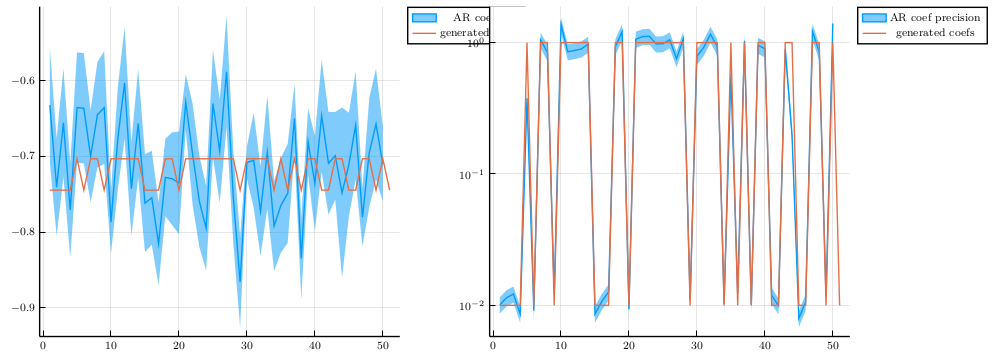

In [76]:
dimension(n) = (x) -> map(i -> i[n], x)
index = 2
p1 = plot(mean.(mθs[end]) |> dimension(index), ribbon = sqrt.(var.(mθs[end]) |> dimension(index)), label="AR coef $(index)")
plot!([coefs_set[state][index] for state in real_states], label="generated coefs")
p2 = plot(mean.(mγs[end]), ribbon = std.(mγs[end]), yscale = :log10, label="AR coef $(precision)")
plot!([prec_set[state] for state in real_states], label="generated coefs")

plot(p1, p2, size = (900, 400))

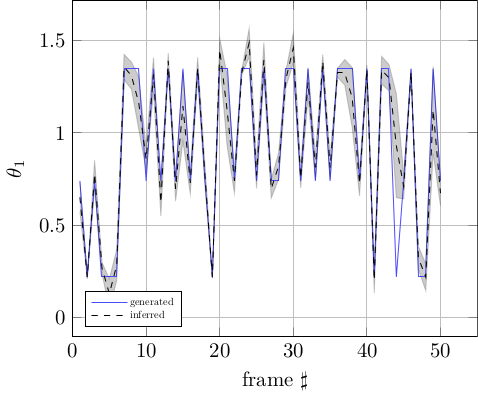

In [373]:
index = 1
dimension(n) = (x) -> map(i -> i[n], x)

plt_states = @pgf Axis(
    {   xlabel="frame "*L" \sharp",
        xmin=0.0,
        legend_pos = "south west",
        legend_cell_align="{left}",
        grid = "major",
        ylabel=L"\theta_{1}",
        legend_style = "{nodes={scale=0.5, transform shape}}",
    },
    Plot({no_marks,color="blue!70"}, Coordinates(collect(1:n_buckets), [coefs_set[state][index] for state in real_states[1:end-1]])), LegendEntry("generated"),
    Plot({no_marks,color="black", style ="{dashed}"}, Coordinates(collect(1:n_buckets), mean.(mθs[end]) |> dimension(index))),
    Plot({"name path=f", no_marks,color="black",opacity=0.2 }, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .+  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({"name path=g", no_marks, color="black",opacity=0.2}, Coordinates(collect(1:n_buckets), (mean.(mθs[end]) |> dimension(index)) .-  (sqrt.(var.(mθs[end]) |> dimension(index))) )),
    Plot({ thick, color = "blue", fill = "black", opacity = 0.2 },
            raw"fill between [of=f and g]"), LegendEntry("inferred")
)


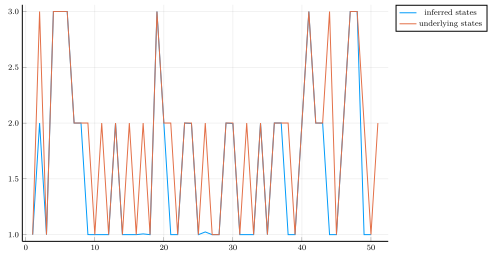

In [374]:
real_states = last.(findmax.(gen_states))
plot(mean.(mzs[end][1:end]), label="inferred states")
plot!(real_states, label="underlying states")

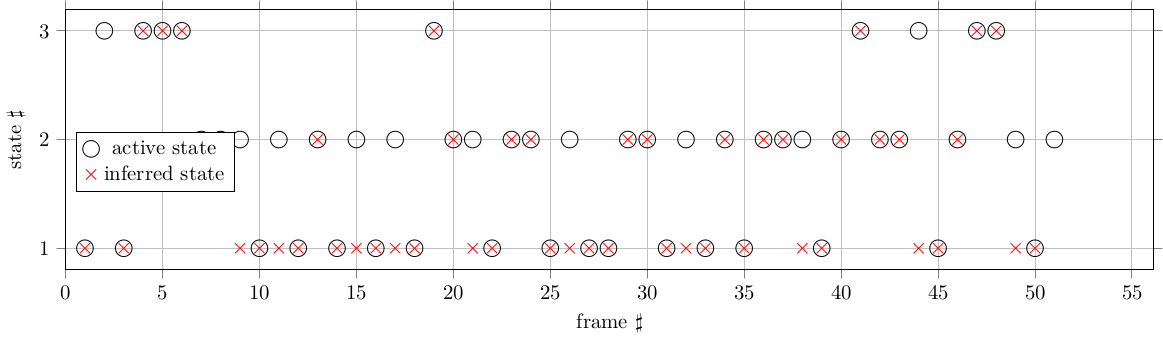

In [375]:
plt_states = @pgf Axis({
    yticklabel_style={
    "/pgf/number format/fixed,
    /pgf/number format/precision=3"
    },
    legend_style="{at={(0.01,0.3)},anchor=south west}",
    grid="major",
    yminorgrids=true,
    xmin=0.0,
    tick_align="outside",
    scaled_y_ticks = false,
    ytick_distance=1, grid = "major", style={"ultra thin"},
    width="20cm", height="6cm",
    xlabel="frame "*L" \sharp", ylabel="state "*L" \sharp",
},
Plot(
    {only_marks,color="black",fill_opacity=0.0, mark_size=4.0, mark="*"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(real_states)), y = real_states
        )
    ), LegendEntry("active state"),
Plot(
    {fill="black", only_marks,color="red", mark_size=3.5, opacity=1.0, mark="x"},
        Table(
            {x = "x", y = "y"},
             x = collect(1:length(mzs[end])), y = round.(mean.(mzs[end][1:end]))
        ),
    ), LegendEntry("inferred state"),
)



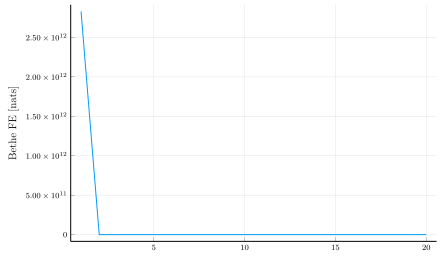

In [376]:
plot(mfe[1:end], label=:none, ylabel="Bethe FE [nats]")

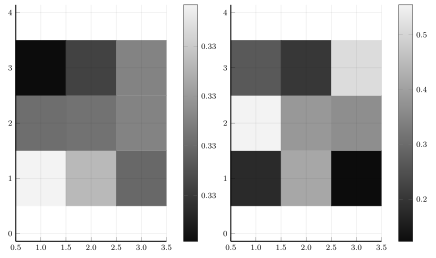

In [434]:
xs = collect(1:n_states)
ys = collect(1:n_states)
p1 = heatmap(xs, ys, mean(mA[end]), aspect_ratio = 1,color=:grays)
p2 = heatmap(xs, ys, gen_A, aspect_ratio = 1, color=:grays)
plot(p1, p2)

In [439]:
collect(1:n_states)

3-element Vector{Int64}:
 1
 2
 3

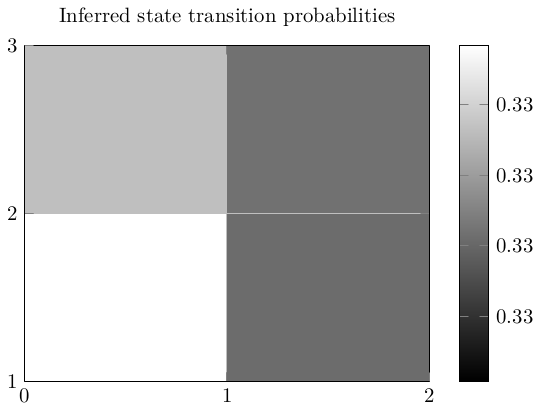

In [466]:
axis1 = @pgf Axis(
    {
        xtick=collect(0:n_states),
        ytick=collect(0:n_states),
        title="Inferred state transition probabilities",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/blackwhite",
        colorbar_style={"xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat corner",
        },
        Coordinates(collect(1:3), collect(1:3), mean(mA[end]))),
    )